# Time-domain analysis.

When sound arrives from any other direction then directly forward we expect a delay between nearest and the furthest (from the source) microphone. Lets analyze this.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import IntSlider
import sounddevice as sd

%matplotlib widget
%reload_ext autoreload
%autoreload 2

# Constant parameters
PI = np.pi
speed_of_sound = 343.0
elem_distance = 3*0.042

# Audio parameters
Fs       = 44100
F0       = speed_of_sound / elem_distance      # probe frequency, why this frequency?
npt      = 128*1024 # per channel
dur      = npt/Fs
nchan    = 16

# Configure Audio devices
dev_in = sd.query_devices("micArray16")
dev_out = sd.query_devices("default") # for Black USB-cable speaker
input_device_id = dev_in['index']
output_device_id = dev_out['index']
print(f"Found devices: in:{input_device_id} out:{output_device_id}")
sd.default.samplerate = Fs
sd.default.channels = nchan
sd.default.device = [input_device_id, output_device_id]


Found devices: in:0 out:2


### Play & Record 3 seconds of audio
We play a 1 kHz sine wave through the speaker and records audio from the array. We record all 16 channels but we choose two (in the horizontal plane) to do our analysis.

In [2]:
# Generate 3 second signal
import numpy as np
from signals import PulseWave
from filters import BandpassFilter, Normalize16

def probe(freq = F0):
    outsmp = PulseWave(npt, Fs, freq, amp=0.2)

    # play & record with 16 mics
    insmp = sd.playrec(outsmp, samplerate=Fs)
    sd.wait()

    return insmp


Probe frequency:  1440


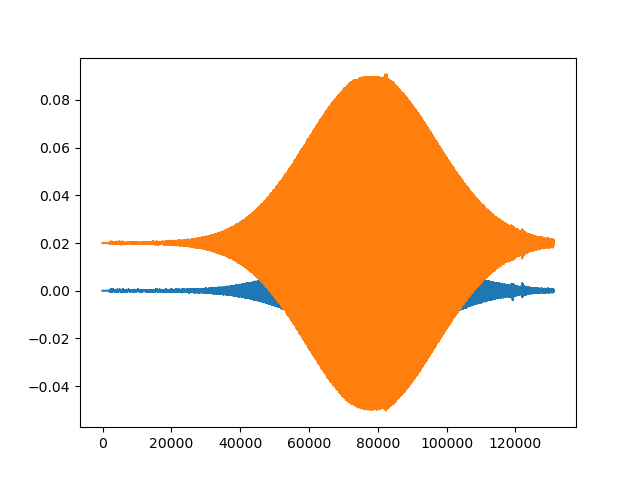

In [3]:
# Select two microphones to compare, one left and one right
mic_dist = 3*elem_distance # mic 2 & 15 are 3 units apart
freq = 1440
print("Probe frequency: ", freq)
insmp = probe(freq)
signal1 = insmp[:, 1]  + insmp[:, 3] + insmp[:, 5] + insmp[:, 7]
signal2 = insmp[:, 14] + insmp[:, 12] + insmp[:, 10] + insmp[:, 8]

plt.close("all")
plt.plot(signal1, '-')
plt.plot(signal2 + 0.02, '-')
plt.show()

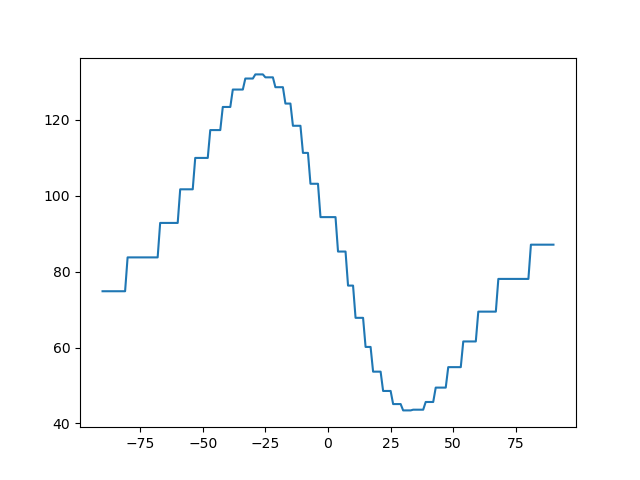

Maximum at angle: -29.0 degrees


In [12]:

def angle2shift(angle):
    angle_rad = np.radians(angle)
    # length difference due to angle-of-incidence
    shift_distance = elem_distance * np.sin(angle_rad)
    # Time difference when sound travels this distance
    shift_time = shift_distance / speed_of_sound
    # Amount of samples in that time
    shift_samples = shift_time * Fs
    return shift_samples

def calc_power(signal1, signal2, shift):
    shift = int(shift)
    if shift > 0:
        signal1 = np.pad(signal1, (shift, 0), 'constant')
        signal2 = np.pad(signal2, (0, shift), 'constant')
    else:
        signal1 = np.pad(signal1, (0, -shift), 'constant')
        signal2 = np.pad(signal2, (-shift, 0), 'constant')

    beam_signal = signal1 + signal2
    power = np.sum(np.power(beam_signal, 2))
    return power
    
def plot_direction(signal1, signal2):
    angles = np.linspace(-90, 90, 181)
    shifts = angle2shift(angles)
    sum_samples = [calc_power(signal1, signal2, shift) for shift in shifts]

    plt.close("all")
    plt.plot(angles, sum_samples)
    plt.show()    
    
    angle_of_max = angles[np.argmax(sum_samples)]
    print(f"Maximum at angle: {angle_of_max} degrees")
        
# # As a start we will choose a wavelength of twice the microphone distance: now the signal will cancel out at 90 degree angels
# freq = speed_of_sound / elem_distance / 2 / 2
# # freq = 700
# print("Probe frequency: ", freq)
# insmp = probe(freq)
# signal1 = insmp[:, 1]  # Mic 2, bottom left
# signal2 = insmp[:, 14] # Mic 15, bottom right

plot_direction(signal1, signal2)


## Improvement: Normalize Audio levels
In this (delay) calculation we don't care about the amplitude difference of the microphones. We can normalize all channels to an amplitude of 1.

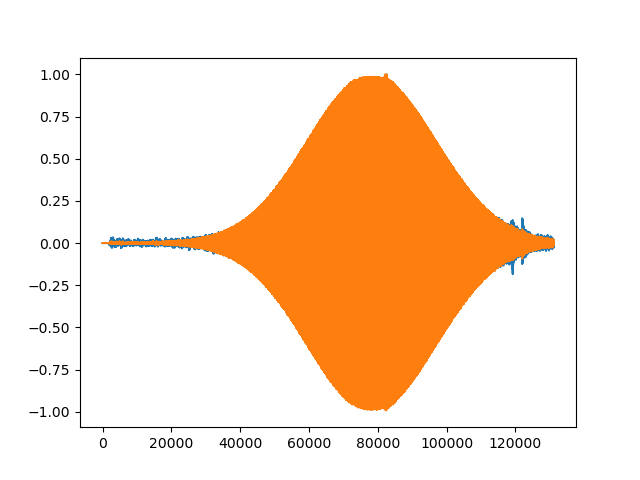

In [5]:
from filters import Normalize
signal1n = Normalize(signal1)
signal2n = Normalize(signal2)

plt.close("all")
plt.plot(signal1n, '-')
plt.plot(signal2n, '-')
plt.show()


### Improve: Bandpass Filter
We know the frequency of our probe signal, so lets just keep that and throw out the other frequencies to see if this improves things

Filtering for frequency:  1440


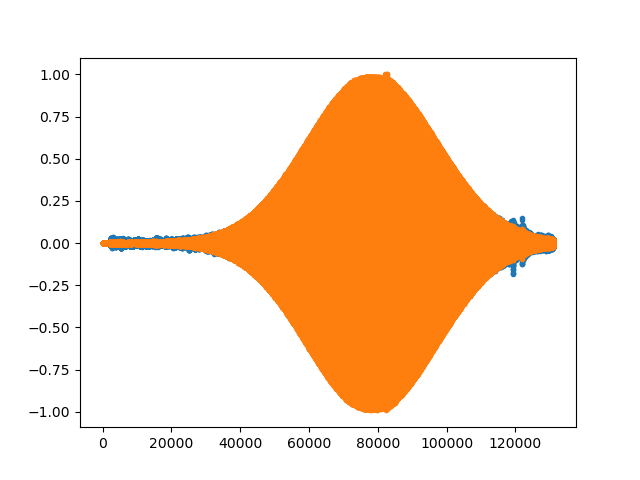

In [11]:
from filters import BandpassFilter

# signal1f = BandpassFilter(signal1, Fs, freq, 200)
# signal2f = BandpassFilter(signal2, Fs, freq, 200)
print("Filtering for frequency: ", freq)
signal1f = Normalize(BandpassFilter(signal1, Fs, freq, 300))
signal2f = Normalize(BandpassFilter(signal2, Fs, freq, 300))
plt.close("all")
plt.plot(signal1n, '.')
plt.plot(signal2n, '.')
plt.plot(signal1f + 1, '-')
plt.plot(signal2f + 1, '-')
plt.show()

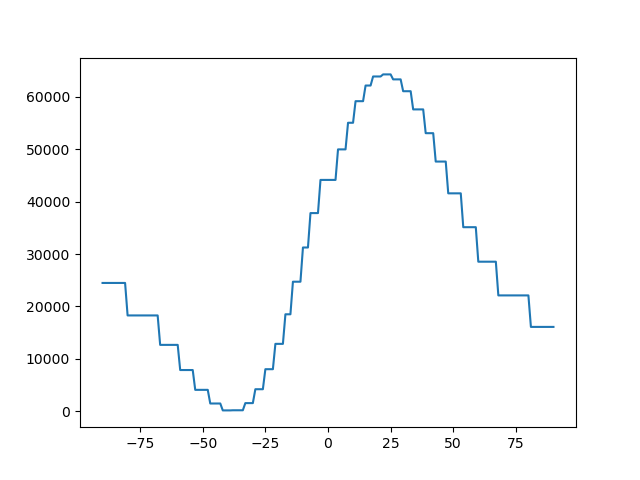

Maximum at angle: 22 degrees


In [44]:
plot_direction(signal1f, signal2f)